# Calculate and plot intrinsic scatter within clusters

In [1]:
from astropy.io import fits
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.stats import multivariate_normal                                                                                                                                                                                                                                                                                                                                                                                                                  
from scipy.optimize import curve_fit
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from astropy.table import Table
from astropy import table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import unique

In [2]:
%matplotlib inline

In [3]:
#define elements we are considering
elements=['C_FE','CI_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',\
          'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
trusted_elements = ['NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','CR_FE','MN_FE',\
                    'FE_H','NI_FE','CU_FE','TI_FE']
final_elements = ['MG_FE','AL_FE','SI_FE','CA_FE','CR_FE','MN_FE','FE_H','NI_FE']

In [4]:
#initialize the Kharchenko catalog
Complete_Clusters=Table.read('C:/Users/vijit/Documents/Repositories/clusterchemistry/clusterchemistry/data/'
                             'Cluster_Catalog_Kharchenko_updated.fits')
Complete_Clusters=Complete_Clusters.to_pandas()
Complete_Clusters['CLUSTER_RADIUS']=Complete_Clusters['CLUSTER_RADIUS']*60.0
for i in range(len(Complete_Clusters)):
    Complete_Clusters['NAME'][i] = Complete_Clusters['NAME'][i].decode("utf-8")
    
for i in range(len(Complete_Clusters)):
    Complete_Clusters['NAME'][i] = Complete_Clusters['NAME'][i].rstrip()

<ipython-input-4-ccc678a23577>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete_Clusters['NAME'][i] = Complete_Clusters['NAME'][i].decode("utf-8")
<ipython-input-4-ccc678a23577>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete_Clusters['NAME'][i] = Complete_Clusters['NAME'][i].rstrip()


In [5]:
# open cluster properties file and initialize
cluster_properties=Table.read('../data/Cluster_properties.fits',format = "fits")
cluster_properties=cluster_properties.to_pandas()
cluster_properties['NO_OF_STARS']=float('nan')
cluster_properties['Metallicity']=float('nan')
cluster_properties['Metallicity_dispersion']=float('nan')
cluster_properties['MG_FE_cluster']=float('nan')
cluster_properties['MG_FE_cluster_dispersion']=float('nan')
cluster_properties['Heliocentric_Distance_Kharchenko']=float('nan')
cluster_properties['Heliocentric_Distance_APOGEE']=float('nan')
cluster_properties['Space_velocity_dispersion_fit']=float('nan')
cluster_properties['Space_velocity_dispersion_fit_err']=float('nan')
cluster_properties['Space_velocity_dispersion_data']=float('nan')
cluster_properties['Space_velocity_dispersion_data_err']=float('nan')
cluster_properties['RV_dispersion_data']=float('nan')
cluster_properties['RV_dispersion_fit']=float('nan')
cluster_properties['RV_dispersion_data_err']=float('nan')
cluster_properties['RV_dispersion_fit_err']=float('nan')
cluster_properties['PM_dispersion_data']=float('nan')
cluster_properties['PM_dispersion_fit']=float('nan')
cluster_properties['PM_dispersion_data_err']=float('nan')
cluster_properties['PM_dispersion_fit_err']=float('nan')


for i in range(len(elements)):
    cluster_properties[elements[i]+'_intrinsic_scatter']=float('nan')
    cluster_properties[elements[i]+'_intrinsic_mean']=float('nan')
    cluster_properties[elements[i]+'_intrinsic_scatter_DC_method']=float('nan')
    cluster_properties[elements[i]+'_intrinsic_mean_uncertainty']=float('nan')
    cluster_properties[elements[i]+'_intrinsic_scatter_uncertainty']=float('nan')
    cluster_properties[elements[i]+'_intrinsic_scatter_uncertainty_DC_method']=float('nan')

for i in range(len(cluster_properties)):
    cluster_properties['Cluster_Name'][i] = cluster_properties['Cluster_Name'][i].decode("utf-8")
    cluster_properties['Cluster_Status'][i] = cluster_properties['Cluster_Status'][i].decode('utf-8')    
    cluster_properties['Validation'][i] = cluster_properties['Validation'][i].decode('utf-8')

<ipython-input-5-89b7ad19d6a7>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_properties['Cluster_Name'][i] = cluster_properties['Cluster_Name'][i].decode("utf-8")
<ipython-input-5-89b7ad19d6a7>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_properties['Cluster_Status'][i] = cluster_properties['Cluster_Status'][i].decode('utf-8')
<ipython-input-5-89b7ad19d6a7>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clus

In [6]:
#open and initialize the cluster members rederived uncertainties file. Use quality cuts and select out giants
giants=Table.read("../data/"+'Cluster_members_rederived_uncertainties')
giants = giants[np.logical_and.reduce((giants['no_sigmas_total'] < 3, giants['TEFF']>3600))]           
giants_unique = unique(giants,keys='APOGEE_ID')
giants_unique = giants_unique[giants_unique['VSCATTER']<1]
giants_unique = giants_unique[giants_unique['LOGG']<3]

giants_unique = giants_unique[np.logical_and.reduce((\
                    giants_unique['STARFLAG'] & 2**17 == 0, giants_unique['STARFLAG'] & 2**2 == 0,\
                    giants_unique['STARFLAG'] & 2**3 == 0, giants_unique['ASPCAPFLAG'] & 2**19 == 0,\
                    giants_unique['ASPCAPFLAG'] & 2**20 == 0, giants_unique['ASPCAPFLAG'] & 2**23 == 0))]

In [7]:
len(giants_unique)

1927

In [8]:
#function to calculate all the required parameters from a givn cluster if conditions are met
def calc_parameters(cluster_name):
    #test if cluster passes required conditions for a 'GOOD' OC
    cluster_cond = cluster_properties['Cluster_Name'] == cluster_name
    if np.logical_and.reduce((cluster_properties['Cluster_Status'][cluster_cond].values == 'OC',\
                              cluster_properties['Validation'][cluster_cond].values == 'GOOD'\
                               ,cluster_properties['Ampl_residual_RV'][cluster_cond].values > 9.5)):
        try:
            cluster_members = giants_unique[np.logical_and(giants_unique['Cluster'] == cluster_name,\
                giants_unique['dist_center']<Complete_Clusters[Complete_Clusters['NAME'] == cluster_name]\
                            ['CLUSTER_RADIUS'].values[0])] #select only central radius stars
            print('No. of cluster members = ',len(cluster_members))
            if (len(cluster_members)>8): 
                print()
                #Run the ML estimator to determine intrinsic scatter within cluster for several elements
                Numerical_estimate(cluster_members, cluster_name)
                return(1.0)
            else:
                print('Less than 11 stars. Error')
                return(0.0)
#         except ValueError:
#             print('ValueError')
#             return(0.0)
        except RuntimeError:
            print('RuntimeError')
            return(0.0)
#         except IndexError:
#             print('IndexError')
#             return(0.0)
        except IOError:
            print('IOError')
            return(np.zeros(10))
#         except KeyError:
#             print('KeyError')
#             return(0.0)      
#         except TypeError:
#             print('TypeError')
#             return(0.0)
        except ZeroDivisionError:
            print('ZeroDivisionError')
            return(0.0)
    else:
        return(0.0)

In [9]:
def Numerical_estimate(joined,cluster_name):    
    from astroML.plotting.mcmc import convert_to_stdev
    from astroML.plotting import setup_text_plots
    #Log function for MLE
    def gaussgauss_logL(xi, ei, mu, sigma):
#         sigma = np.exp(lnsigma)
        """Equation 5.63: gaussian likelihood with gaussian errors"""
        ndim = len(np.broadcast(sigma, mu).shape)

        xi = xi.reshape(xi.shape + tuple(ndim * [1]))
        ei = ei.reshape(ei.shape + tuple(ndim * [1]))

        s2_e2 = sigma ** 2 + ei ** 2
        return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)

    # initialize the parameters
    mu_0=np.zeros(len(trusted_elements))
    mu_0_uncert=np.zeros(len(trusted_elements))
    sigma_0=np.zeros(len(trusted_elements))
    sigma_0_uncert=np.zeros(len(trusted_elements))
    mean_uncert=np.zeros(len(trusted_elements))
    med_uncert=np.zeros(len(trusted_elements))
    std_abund=np.zeros(len(trusted_elements))
    no_members=np.zeros(len(trusted_elements))
    
    #iterate over each elements
    for i in range(len(trusted_elements)):
        N = 10
        #quality cut
        ei = joined[trusted_elements[i]+'_uncertainty_derived'][joined[trusted_elements[i]]>-9000]
        xi = joined[trusted_elements[i]][joined[trusted_elements[i]]>-9000]
        #if too little stars
        if (len(xi)<5):
            sigma_0[i] = np.nan
            sigma_0_uncert[i] = np.nan
            continue
        
        #initialize the plane to search in
        sigma = np.linspace(0.0001, 0.12, 10000)
        mu = np.linspace(-1.0, 1.0, 100)
        #define the log space
        logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
        logL -= logL.max()

        plane=np.meshgrid(mu,sigma)
        #select the values of the parameters with maximum Log likelihood
        mu_0[i]=plane[0].reshape(-1)[np.argmax(logL)]
        sigma_0[i]=plane[1].reshape(-1)[np.argmax(logL)]
        mean_uncert[i]=np.mean(ei)
        med_uncert[i]=np.median(ei)
        std_abund[i]=np.std(xi)
        no_members[i]=len(xi)
        #calculate the uncertainties in the parameters
        def gauss(x, mu, sigma, A):
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        el=np.exp(logL)
        el_sum=np.zeros(len(el))
        #sum over one parameter and fi a Gaussian on the PDF of the other parameter
        for j in range(len(el)):
            el_sum[j]=np.sum(el[j,:])
        par,var=curve_fit(gauss, sigma, el_sum, bounds=([-1.0,0.00001,np.max(el_sum)-0.01],\
                                                        [1.0,0.007,np.max(el_sum)+0.01]))
        sigma_0_uncert[i]=par[1] # Sigma of the fit Gaussian is the uncertainty
    
    #attribute the calculated values to the table
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,\
        [i+'_intrinsic_scatter' for i in trusted_elements]]=sigma_0

    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,\
        [i+'_intrinsic_scatter_uncertainty' for i in trusted_elements]]=sigma_0_uncert

    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,\
        [i+'_intrinsic_mean' for i in trusted_elements]]=mu_0

    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,\
        [i+'_intrinsic_mean_uncertainty' for i in trusted_elements]]=mu_0_uncert

    cluster_cond = cluster_properties['Cluster_Name']==cluster_name
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Metallicity']]=\
        np.mean(joined['M_H'][joined['M_H']>-9000])
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Metallicity_dispersion']]=\
        np.std(joined['M_H'][joined['M_H']>-9000])
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['MG_FE_cluster']]=\
        np.mean(joined['MG_FE'][joined['MG_FE']>-9000])
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['MG_FE_cluster_dispersion']]=\
        np.std(joined['MG_FE'][joined['MG_FE']>-9000])
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Heliocentric_Distance_APOGEE']]=\
        np.mean(joined['D2_med'][~np.isnan(joined["D2_med"])])
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Heliocentric_Distance_err_APOGEE']]=\
        np.std(joined['D2_med'][~np.isnan(joined["D2_med"])])
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Velocity_dispersion']]=\
        np.std(joined['VHELIO_AVG'][joined['VHELIO_AVG']<5000])
        
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['RV_dispersion_data']]=\
        MLE_velocity_dispersion(joined['VHELIO_AVG'],joined['VERR'])[1]
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['RV_dispersion_fit']]=\
        cluster_properties['RV_fit_Std_Dev']
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['RV_dispersion_data_err']]=\
        MLE_velocity_dispersion(joined['VHELIO_AVG'],joined['VERR'])[2]
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['RV_dispersion_fit_err']]=\
        MLE_velocity_dispersion(joined['VHELIO_AVG'],joined['VERR'])[2]
        
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['PM_dispersion_data']]=\
        np.sqrt((MLE_velocity_dispersion(joined['GAIA_PMRA'],joined['GAIA_PMRA_ERROR'])[1]**2 + \
        MLE_velocity_dispersion(joined['GAIA_PMDEC'],joined['GAIA_PMDEC_ERROR'])[1]**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2))
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['PM_dispersion_fit']]=\
        np.sqrt((cluster_properties['PM_fit_RA_Std_Dev']**2 + \
                cluster_properties['PM_fit_DEC_Std_Dev']**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2))
        
       
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['PM_dispersion_data_err']]=\
        0.25*(MLE_velocity_dispersion(joined['GAIA_PMRA'],joined['GAIA_PMRA_ERROR'])[1]**2 + \
                  MLE_velocity_dispersion(joined['GAIA_PMDEC'],joined['GAIA_PMDEC_ERROR'])[1]**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2)\
            /cluster_properties.loc[cluster_cond,'Space_velocity_dispersion_data']
        
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['PM_dispersion_fit_err']]=\
        0.25*(cluster_properties['PM_fit_RA_Std_Dev']**2 + \
                cluster_properties['PM_fit_DEC_Std_Dev']**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2)\
            /cluster_properties.loc[cluster_cond,'Space_velocity_dispersion_fit']
        
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Space_velocity_dispersion_data']]=\
        np.sqrt(MLE_velocity_dispersion(joined['VHELIO_AVG'],joined['VERR'])[1]**2 +\
        (MLE_velocity_dispersion(joined['GAIA_PMRA'],joined['GAIA_PMRA_ERROR'])[1]**2 + \
        MLE_velocity_dispersion(joined['GAIA_PMDEC'],joined['GAIA_PMDEC_ERROR'])[1]**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2))
    
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Space_velocity_dispersion_fit']]=\
        np.sqrt(cluster_properties['RV_fit_Std_Dev']**2 +\
        (cluster_properties['PM_fit_RA_Std_Dev']**2 + \
        cluster_properties['PM_fit_DEC_Std_Dev']**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2))

    
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Space_velocity_dispersion_data_err']]=\
            0.25*(MLE_velocity_dispersion(joined['GAIA_PMRA'],joined['GAIA_PMRA_ERROR'])[1]**2 + \
                  MLE_velocity_dispersion(joined['GAIA_PMDEC'],joined['GAIA_PMDEC_ERROR'])[1]**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2)\
            /cluster_properties.loc[cluster_cond,'Space_velocity_dispersion_data']

    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['Space_velocity_dispersion_fit_err']]=\
            0.25*(cluster_properties['PM_fit_RA_Std_Dev']**2 + \
                cluster_properties['PM_fit_DEC_Std_Dev']**2)*\
             ((3.09*10**16*np.pi*10**-3)/(3.15*180*60*60*10**7)*\
              cluster_properties.loc[cluster_cond,'Heliocentric_Distance_APOGEE']**2)\
            /cluster_properties.loc[cluster_cond,'Space_velocity_dispersion_fit']

#includes conversion from mas/year to km/s  
                    
    cluster_properties.loc[cluster_properties['Cluster_Name']==cluster_name,['NO_OF_STARS']]=len(joined)


In [10]:
def MLE_velocity_dispersion(xi,ei):
    from astroML.plotting.mcmc import convert_to_stdev

    from astroML.plotting import setup_text_plots
    setup_text_plots(fontsize=8, usetex=True)
    def gaussgauss_logL(xi, ei, mu, sigma):
        """Equation 5.63: gaussian likelihood with gaussian errors"""
        ndim = len(np.broadcast(sigma, mu).shape)

        xi = xi.reshape(xi.shape + tuple(ndim * [1]))
        ei = ei.reshape(ei.shape + tuple(ndim * [1]))

        s2_e2 = sigma ** 2 + ei ** 2
        return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)

    mu_0=np.zeros(len(elements))
    sigma_0=np.zeros(len(elements))
    sigma_0_uncert=np.zeros(len(elements))
    
    sigma = np.linspace(np.std(xi)-10, np.std(xi)+1.0, 1000)
    mu = np.linspace(np.mean(xi)-10.0, np.mean(xi)+1.0, 1000)

    logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
    logL -= logL.max()

    plane=np.meshgrid(mu,sigma)
    mu_0=plane[0].reshape(-1)[np.argmax(logL)]
    sigma_0=plane[1].reshape(-1)[np.argmax(logL)]
    #find uncertainty in sigma_0 by taking pdf of the Likelihood function
    def gauss(x, mu,sigma,A):
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    if sigma_0>0.0002:
        el=np.exp(logL)
        el_sum=np.zeros(len(el))
        for j in range(len(el)):
            el_sum[j]=np.sum(el[j,:])
        try:
            par,var=curve_fit(gauss, sigma, el_sum)
            sigma_0_uncert=par[1]
        except:
            sigma_0_uncert=np.mean(ei)#/(sigma_0*2) #derived mathematically
    else:
        sigma_0=np.std(xi) # if MLE fails, set intrinsic scatter (upper limit) to dispersion
        sigma_0_uncert=np.mean(ei)#/(sigma_0*2) #derived mathematically
    return mu_0,sigma_0, sigma_0_uncert

# Run the ML Estimator for all clusters

In [11]:
sum_clusters=0.0
for i in range(len(cluster_properties)):
    sum_clusters += calc_parameters(cluster_properties['Cluster_Name'][i])


No. of cluster members =  0
Less than 11 stars. Error
No. of cluster members =  0
Less than 11 stars. Error
No. of cluster members =  1
Less than 11 stars. Error
No. of cluster members =  7
Less than 11 stars. Error
No. of cluster members =  0
Less than 11 stars. Error
No. of cluster members =  8
Less than 11 stars. Error
No. of cluster members =  2
Less than 11 stars. Error
No. of cluster members =  4
Less than 11 stars. Error
No. of cluster members =  3
Less than 11 stars. Error
No. of cluster members =  2
Less than 11 stars. Error
No. of cluster members =  3
Less than 11 stars. Error
No. of cluster members =  6
Less than 11 stars. Error
No. of cluster members =  4
Less than 11 stars. Error
No. of cluster members =  5
Less than 11 stars. Error
No. of cluster members =  2
Less than 11 stars. Error
No. of cluster members =  0
Less than 11 stars. Error
No. of cluster members =  6
Less than 11 stars. Error
No. of cluster members =  6
Less than 11 stars. Error
No. of cluster members =  0


In [12]:
#Using central radius as cluster radius for the MLE calculations
for i, cluster_name in enumerate(cluster_properties['Cluster_Name']):
    cluster_properties['Cluster_Radius'].loc[i] = \
        Complete_Clusters[Complete_Clusters['NAME'] == cluster_name]['CENTRAL_RADIUS'].values
cluster_cond = ~np.isnan(cluster_properties['Heliocentric_Distance_APOGEE'])
#defining heliocentric positions and calculating Galactocentric distance
h = SkyCoord(ra = cluster_properties['Cluster_Center_RA'][cluster_cond].values*u.degree,
            dec = cluster_properties['Cluster_Center_DEC'][cluster_cond].values*u.degree,
            distance = cluster_properties['Heliocentric_Distance_APOGEE'][cluster_cond].values*u.kpc)#transforming to galactocentric positions
gc = h.transform_to('galactocentric')
#defining the center of the galaxy
center = SkyCoord(ra = 266.416833*u.degree,
                 dec = -29.007806*u.degree,
                 distance = 8.3*u.kpc)
#calculating the direct distance from the center for each point
true_gc = gc.separation_3d(center)

cluster_properties['z_height'] = np.nan
cluster_properties['z_height'][cluster_cond] = gc.z.value#get the radial distance from GC along the plane

cluster_properties['Galactocentric_Distance'] = np.nan
cluster_properties['Galactocentric_Distance'][cluster_cond] = np.sqrt(gc.x.value**2 + gc.y.value**2)

cluster_properties['Galactocentric_Distance_err'] = np.nan
cluster_properties['Galactocentric_Distance_err'][cluster_cond] = 0.25 * h.distance * (h.distance.value + \
                        center.distance.value* np.cos((180-h.transform_to('galactic').l.value) * \
                        np.pi/180))/cluster_properties['Galactocentric_Distance'][cluster_cond]

#calculating cluster size
cluster_properties['Cluster_Size'] = cluster_properties['Cluster_Radius']*np.pi/180 *\
                                    cluster_properties['Heliocentric_Distance_APOGEE']*1000
cluster_properties['Cluster_Size_err'] = 0.25 * cluster_properties['Heliocentric_Distance_APOGEE']*1000 * \
                                            cluster_properties['Cluster_Radius']*np.pi/180

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-12-ad5107bdd5b6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_properties['z_height'][cluster_cond] = gc.z.value#get the radial distance from GC along the plane
<ipython-input-12-ad5107bdd5b6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c

In [13]:
cluster_properties['z_height'] = abs(cluster_properties['z_height'])
temp_cond = cluster_properties['log_age_err']>0.000000001
cluster_properties['log_age_err_cond'] = np.nan
cluster_properties.loc[temp_cond, 'log_age_err_cond'] = cluster_properties.loc[temp_cond, 'log_age']

In [14]:
# cluster_properties.to_csv('../data/Cluster_intrinsic_scatter', overwrite=False)

In [15]:
#Read the intrinsic scatter file

In [5]:
cluster_properties=pd.read_csv('./data/Cluster_intrinsic_scatter',index_col=0)
cond = ~np.isnan(cluster_properties['Heliocentric_Distance_APOGEE'])

In [6]:
cluster_properties[[i+'_intrinsic_scatter' for i in final_elements]][cond]

,MG_FE_intrinsic_scatter,AL_FE_intrinsic_scatter,SI_FE_intrinsic_scatter,CA_FE_intrinsic_scatter,CR_FE_intrinsic_scatter,MN_FE_intrinsic_scatter,FE_H_intrinsic_scatter,NI_FE_intrinsic_scatter
218,0.024634,0.023363,0.015365,0.025162,0.058209,0.000100,0.021109,0.012763
228,0.014322,0.034143,0.000100,0.014825,0.013518,0.023962,0.021924,0.007439
237,0.041386,0.048556,0.042585,0.022452,0.000100,0.013446,0.042261,0.006803
249,0.015988,0.020989,0.000100,0.020221,0.043040,0.015737,0.031421,0.000100
254,0.014537,0.013218,0.015341,0.000100,0.072791,0.013446,0.026277,0.002834
282,0.012379,0.027560,0.011192,0.016084,0.032656,0.009621,0.035930,0.007235
283,0.031841,0.070944,0.020461,0.026349,0.069277,0.114616,0.049072,0.028483
286,0.008086,0.032860,0.021073,0.017367,0.024598,0.025186,0.034359,0.010005
300,0.003158,0.030018,0.010245,0.012847,0.000100,0.024562,0.031865,0.000100
361,0.020041,0.057634,0.012259,0.018351,0.035726,0.033124,0.077107,0.016108


In [7]:
elem_titles = ['[Mg/Fe]', '[Al/Fe]', '[Si/Fe]', '[Ca/Fe]', '[Cr/Fe]', '[Mn/Fe]', '[Fe/H]', '[Ni/Fe]']

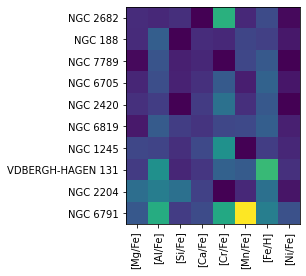

In [8]:
#visualize the scatter
scatters_clusters = np.array([cluster_properties.sort_values(by = 'Space_velocity_dispersion_fit')\
                              [final_elements[i]+'_intrinsic_scatter'][cond].values for\
          i in range(len(final_elements))])
scatters_clusters = scatters_clusters.transpose()
plt.imshow(scatters_clusters,interpolation = 'None')
_=plt.xticks(range(len(elem_titles)),elem_titles, rotation = 'vertical')
_=plt.yticks(range(len(cluster_properties[cond])),\
    cluster_properties.sort_values(by = 'Space_velocity_dispersion_fit')['Cluster_Name'][cond])
# plt.title('Cluster Name vs [X/Fe] scatter')
# plt.colorbar(label = '[X/Fe] intrinsic scatter')
# plt.savefig('Cluster_Name_vs_X_FE_intrinsic_scatter_Anils_suggestion.png', dpi = 200, bbox_inches = 'tight')

Text(0.5, 0.07, 'Space velocity dispersion (km/s)')

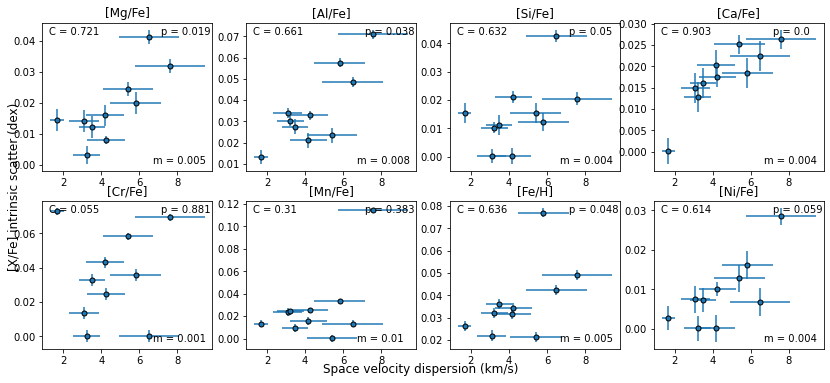

In [9]:
#intrinsic scatter vs space velocity dispersion
corr = np.zeros(len(final_elements))
p_val = np.zeros(len(final_elements))
linregress_pars = np.zeros([len(final_elements), 5])

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (14,6))
for i, this_elem in enumerate(final_elements):
    ax[int(i/4),(i%4)].errorbar(cluster_properties['Space_velocity_dispersion_fit'][cond],\
                cluster_properties[this_elem+'_intrinsic_scatter'][cond],\
                    xerr = cluster_properties['Space_velocity_dispersion_fit_err'][cond].values,\
                        yerr = cluster_properties[this_elem+'_intrinsic_scatter_uncertainty'][cond].values, marker = '.',\
                                linestyle = 'none', capsize = 0.0, markersize = 10, markeredgecolor = 'k')
    ax[int(i/4),(i%4)].set_title(elem_titles[i], fontsize = 12)

    #linear regression
    linregress_pars[i,:] = stats.linregress(cluster_properties['Space_velocity_dispersion_fit'][cond],\
                                  cluster_properties[this_elem+'_intrinsic_scatter'][cond])
    #spearman correlation
    corr[i], p_val[i] = stats.spearmanr(cluster_properties['Space_velocity_dispersion_fit'][cond],\
                                  cluster_properties[this_elem+'_intrinsic_scatter'][cond])
    ax[int(i/4),(i%4)].text(0.04,0.92,'C = '+str(round(corr[i],3)), transform = ax[int(i/4),(i%4)].transAxes)
    ax[int(i/4),(i%4)].text(0.7,0.92,'p = '+str(round(p_val[i],3)), transform = ax[int(i/4),(i%4)].transAxes)
    ax[int(i/4),(i%4)].text(0.65,0.05,'m = '+str(round(linregress_pars[i,0],3)), transform = ax[int(i/4),(i%4)].transAxes)
    ax[int(i/4),(i%4)].set_xticks(ticks = [2,4,6,8], minor = True)
fig.text(0.09, 0.5, '[X/Fe] intrinsic scatter (dex)', va = 'center', rotation = 'vertical', size = 12)
fig.text(0.5, 0.07, 'Space velocity dispersion (km/s)', ha = 'center', size = 12)
# plt.savefig('Dependence_of_cluster_X_Fe_homogeneity_on_space_velocity_dispersion.png', dpi = 200)


Text(0, 0.5, 'Correlation Coefficient')

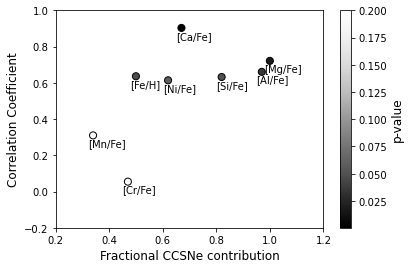

In [10]:
#intrinsic scatter and the FCC of the element
fcc = [1.0, 0.97, 0.82, 0.67, 0.47, 0.34, 0.5, 0.62]
plt.scatter(fcc, corr, c = p_val, s = 50, edgecolor = 'k', cmap = 'Greys_r', vmax=0.20)
for i in range(len(final_elements)):
    plt.annotate(elem_titles[i],(fcc[i]-0.02, corr[i]-0.06))
cbar = plt.colorbar()
cbar.set_label('p-value', fontsize = 12)
plt.xlim(0.2, 1.2)
plt.ylim(-0.2, 1.0)

plt.xlabel('Fractional CCSNe contribution', fontsize = 12)
plt.ylabel('Correlation Coefficient', fontsize = 12)
# plt.savefig('fcc_vs_vel_disp_correlation_coeff_recreation_attempt_colored by slope.png', dpi = 200)

Text(0.085, 0.5, '[Mg/Fe] intrinsic scatter (dex)')

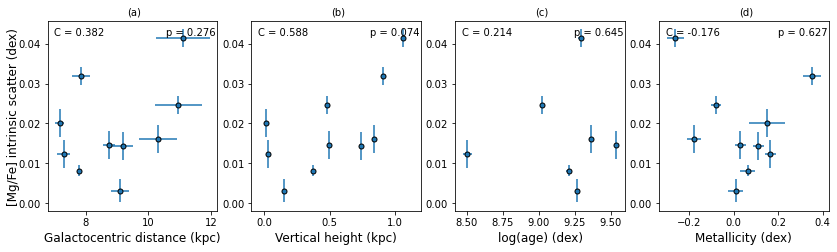

In [11]:
#intrinsic scatter vs other Galactic and cluster parameters
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (14,3.5))

cond = ~np.isnan(cluster_properties['Heliocentric_Distance_APOGEE'])
this_elem = 'MG_FE'
ax[0].errorbar(cluster_properties['Galactocentric_Distance'][cond],\
        cluster_properties[this_elem+'_intrinsic_scatter'][cond],\
            xerr = cluster_properties['Galactocentric_Distance_err'][cond].values,\
                yerr = cluster_properties[this_elem+'_intrinsic_scatter_uncertainty'][cond].values, marker = '.',\
                        linestyle = 'none', capsize = 0.0, markersize = 10, markeredgecolor = 'k')
ax[0].set_xlabel('Galactocentric distance (kpc)', fontsize = 12)
corr, p_val = stats.spearmanr(cluster_properties['Galactocentric_Distance'][cond],\
                              cluster_properties[this_elem+'_intrinsic_scatter'][cond])
ax[0].text(0.47,1.03,'(a)', transform = ax[0].transAxes)
ax[0].text(0.04,0.92,'C = '+str(round(corr,3)), transform = ax[0].transAxes)
ax[0].text(0.7,0.92,'p = '+str(round(p_val,3)), transform = ax[0].transAxes)

ax[1].errorbar(cluster_properties['z_height'][cond],\
        cluster_properties[this_elem+'_intrinsic_scatter'][cond],\
#             xerr = cluster_properties['Galactocentric_Distance_err'][cond].values,\
                yerr = cluster_properties[this_elem+'_intrinsic_scatter_uncertainty'][cond].values, marker = '.',\
                        linestyle = 'none', capsize = 0.0, markersize = 10, markeredgecolor = 'k')
ax[1].set_xlabel('Vertical height (kpc)', fontsize = 12)
corr, p_val = stats.spearmanr(cluster_properties['z_height'][cond],\
                              cluster_properties[this_elem+'_intrinsic_scatter'][cond])
ax[1].text(0.47,1.03,'(b)', transform = ax[1].transAxes)
ax[1].text(0.04,0.92,'C = '+str(round(corr,3)), transform = ax[1].transAxes)
ax[1].text(0.7,0.92,'p = '+str(round(p_val,3)), transform = ax[1].transAxes)
ax[1].set_xlim(-0.1,1.2)

cond = np.logical_and(~np.isnan(cluster_properties['Heliocentric_Distance_APOGEE']),\
                          cluster_properties['log_age_err']>0.0000001)
ax[2].errorbar(cluster_properties['log_age'][cond],\
        cluster_properties[this_elem+'_intrinsic_scatter'][cond],\
            xerr = cluster_properties['log_age_err'][cond].values,\
                yerr = cluster_properties[this_elem+'_intrinsic_scatter_uncertainty'][cond].values, marker = '.',\
                        linestyle = 'none', capsize = 0.0, markersize = 10, markeredgecolor = 'k')
ax[2].set_xlabel('log(age) (dex)', fontsize = 12)
corr, p_val = stats.spearmanr(cluster_properties['log_age'][cond],\
                              cluster_properties[this_elem+'_intrinsic_scatter'][cond])
ax[2].text(0.47,1.03,'(c)', transform = ax[2].transAxes)
ax[2].text(0.04,0.92,'C = '+str(round(corr,3)), transform = ax[2].transAxes)
ax[2].text(0.7,0.92,'p = '+str(round(p_val,3)), transform = ax[2].transAxes)

cond = ~np.isnan(cluster_properties['Heliocentric_Distance_APOGEE'])
ax[3].errorbar(cluster_properties['Metallicity'][cond],\
        cluster_properties[this_elem+'_intrinsic_scatter'][cond],\
            xerr = cluster_properties['Metallicity_dispersion'][cond].values,\
                yerr = cluster_properties[this_elem+'_intrinsic_scatter_uncertainty'][cond].values, marker = '.',\
                        linestyle = 'none', capsize = 0.0, markersize = 10, markeredgecolor = 'k')
ax[3].set_xlabel('Metallicity (dex)', fontsize = 12)
corr, p_val = stats.spearmanr(cluster_properties['Metallicity'][cond],\
                              cluster_properties[this_elem+'_intrinsic_scatter'][cond])
ax[3].text(0.47,1.03,'(d)', transform = ax[3].transAxes)
ax[3].text(0.04,0.92,'C = '+str(round(corr,3)), transform = ax[3].transAxes)
ax[3].text(0.7,0.92,'p = '+str(round(p_val,3)), transform = ax[3].transAxes)


# ax[0].set_xticks(ticks = [2,4,6,8], minor = True)
fig.text(0.085, 0.5, '[Mg/Fe] intrinsic scatter (dex)', va = 'center', rotation = 'vertical', size = 12)
# fig.text(0.5, 0.07, 'Space velocity dispersion (km/s)', ha = 'center', size = 12)
# plt.savefig('Dependence_of_cluster_X_Fe_homogeneity_on_properties_with_no_trend.png', dpi = 200, bbox = 'tight_layout')
